Loading Data

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
articles = pd.read_csv('articles.csv')

Preprocessing Data

In [2]:
articles.head()

,Unnamed: 0,title,date,stock
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A
2,2.0,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A


In [3]:
import nltk
from datetime import datetime as dt
import pytz
from nltk.corpus import stopwords
nltk.download('stopwords')

# Credit to / help from https://saturncloud.io/blog/how-to-remove-stop-words-from-a-pandas-dataframe-using-python/
def remove_stopwords(words_tokenized):
    stop_words = set(stopwords.words('english'))  # List of english stopwords
    return [word for word in words_tokenized if word not in stop_words] # Using list comprehension, only choose the words that aren't stopwords

def convert_to_datetime(date_string):
    
    date_string, _ = date_string.rsplit("-", 1)
    
    converted_date = dt.strptime(date_string, '%Y-%m-%d %H:%M:%S')
    return converted_date

def preprocess(df, sample_size=None):
    df = df.dropna()
    # sample if specified
    if sample_size:
        df = df.sample(sample_size)
    # remove uncessary index column
    df = df.drop(df.columns[0], axis=1)
    # change stock column name to ticker
    df.rename(columns={'stock': 'ticker'}, inplace=True)
    # convert headlines to lowercase
    # convert to datetime object
    df['date'] = df['date'].apply(convert_to_datetime)
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yiann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Grab Stock Returns

Based on the time of the article published, we will retrieve two adjusted close prices of the stock and compute the corresponding return.

If the time of the article is published before 4:00 P.M. (non-inclusive), then:
1. The 'before' price will be the most recent (before the date) trading day's adjusted close price
2. The 'after' price will be the most upcoming trading day's adjusted close price

If the time of the article is published after 4:00 P.M., then:
1. The 'before' price will be the same day's adjusted close price
2. The 'after' priec will be the next day's adjusted close price

In [4]:
import pandas_market_calendars as mcal
from datetime import timedelta
# The paramater forward is a boolean representing whether we are looking for the next valid trading day or the most recent trading day
def getValidTradingCloseDate(date, forward=True):
        nyse = mcal.get_calendar('NYSE')
        if forward:
            start_date = date
            end_date = date+timedelta(days=15)
        else:
            start_date = date-timedelta(days=15)
            end_date = date

        validTradingDays = nyse.valid_days(start_date=start_date , end_date=end_date)
        return validTradingDays.date[2] if forward else validTradingDays.date[-2]


In [5]:
#Get all the yfinance data we need based on date.
import yfinance as yf

def retrieve_yfinance_data(row):
    curr_date = row['date']
    
    eod = dt.strptime('16:00:00', '%H:%M:%S').time()
    
    if curr_date.time() > eod:
        start_date = curr_date.date()
        end_date = getValidTradingCloseDate(start_date, forward=True)
    else:
        end_date = curr_date.date()
        start_date = getValidTradingCloseDate(end_date, forward=False)
        end_date = end_date + timedelta(days=1)
        
    data = yf.download(row['ticker'], start=start_date, end=end_date, progress=False, show_errors=False)
    
    if len(data) > 0:
        returns = (data['Adj Close'][-1] - data['Adj Close'][0]) / data['Adj Close'][0]
        return returns
    else:
        return None

In [6]:
from tqdm import tqdm

def get_returns(df):
    # df['returns'] = df.apply(retrieve_yfinance_data, axis=1)
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        returns = retrieve_yfinance_data(row)
        # print(returns)
        df.loc[idx,'returns'] = returns

    return df

Uncomment this code to 
1. sample two datasets of 50k samples from the 800k+ samples from the dataset.
2. save each dataset to its own pkl file 

*Note: We saved 2 datasets of 50k samples each because we had two people download them simultaneously to save time.


In [7]:
small_test_set = preprocess(articles, sample_size=100)
small_test_set = get_returns(small_test_set)
pd.to_pickle(small_test_set, 'small_test_set.pkl')


# fifty_thousand_articles_2 = preprocess(articles, sample_size=50000)
# fifty_thousand_articles_2 = get_returns(50k_articles_2)
# pd.to_pickle(fifty_thousand_articles_2, '50k_processed_articles_2.pkl')

100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


In [12]:
small_test_set

,title,date,ticker,returns
219534,"Benzinga’s Top Upgrades (SBNY, CCL, MPW, MA, F...",2010-05-21 08:27:00,CCL,0.013952
912659,"Top Performing Industries For August 9, 2016",2016-08-09 10:54:00,NTL,-0.010309
165581,Bridgeline DIgital Reports Q3 Loss $0.26 Vs Es...,2015-08-14 08:01:00,BLIN,-0.048276
1355251,"Earnings Scheduled For March 24, 2015",2015-03-24 04:04:00,WSCI,0.001757
362331,Puts Purchased on Dick's Sporting Goods (DKS),2011-01-06 12:40:00,DKS,-0.045442
...,...,...,...,...
1236358,Standpoint Research Downgrades Tempur-pedic In...,2013-10-01 11:17:00,TPX,0.023658
1370405,"Sector Update: Utilities Leading, Consumer Goo...",2011-08-24 10:36:00,XLF,0.026678
90206,Aramark Acquires On-Demand Food Delivery Servi...,2019-08-06 06:44:00,ARMK,0.047018
1342675,Wheeler Real Estate Investment Trust Responds ...,2018-03-16 04:19:00,WHLR,0.064220


In [14]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
def tokenize_headline(headline):
    return tokenizer.encode_plus(headline, max_length=512, truncation=True, padding='max_length', return_tensors='pt')

small_test_set['tokenized_title'] = small_test_set['title'].apply(tokenize_headline)

In [19]:
print(small_test_set['title'].iloc[0])
small_test_set["tokenized_title"].iloc[0]

Benzinga’s Top Upgrades (SBNY, CCL, MPW, MA, FRED)


{'input_ids': tensor([[  101, 17770, 28234,  1521,  1055,  2327, 18739,  1006, 24829,  4890,
          1010, 10507,  2140,  1010,  6131,  2860,  1010,  5003,  1010,  5965,
          1007,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

Merge Two Datasets into 1 Dataset

In [8]:
# load both datasets
dataset_1 = pd.read_pickle('50k_processed_data_1.pkl')
dataset_2 = pd.read_pickle('50k_processed_data_2.pkl')

# merge the two datasets (disclude repeated rows)
dataset = pd.concat([dataset_1, dataset_2], axis=0)

# eliminate rows with the same index
dataset = dataset[~dataset.index.duplicated(keep='first')]

len(dataset)

67321

Split Dataset into Training, Validation, and Testing

In [9]:
from sklearn.model_selection import train_test_split

def split(df):
    x_train, x_test_and_val, y_train, y_test_and_val  = train_test_split(df['title'], df['returns'], random_state=42, test_size=0.2) # train set is 80%,
    x_test, x_val, y_test, y_val = train_test_split(x_test_and_val, y_test_and_val, test_size=0.5, random_state=42) # test and val are 50% of the remaining 20% = 10%. 
    return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = split(dataset) # split the data


Return Distribution Analysis

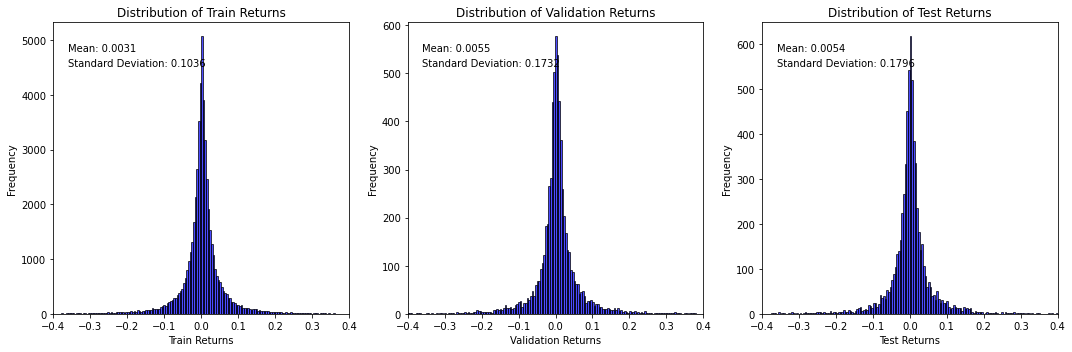

In [10]:
# Analyze the articles dataset distribution
import matplotlib.pyplot as plt
import numpy as np

def plot_returns(ax, datasetType, returns, bins=None):
    # If bins isn't specified, set it to 1/10th of the number of returns

    ax.hist(returns, bins=bins, alpha=0.7, color='b', edgecolor='black')
    ax.set_xlabel(f'{datasetType} Returns')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {datasetType} Returns')
    ax.set_xlim(-0.4, 0.4)

    # Calculate mean and standard deviation
    mean_return = np.mean(returns)
    std_deviation = np.std(returns)

    # Add mean and standard deviation to the plot
    ax.text(0.05, 0.9, f'Mean: {mean_return:.4f}', transform=ax.transAxes)
    ax.text(0.05, 0.85, f'Standard Deviation: {std_deviation:.4f}', transform=ax.transAxes)

def display_return_plots(y_train, y_val, y_test):
    # Create subplots
    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot train, val, and test returns
    plot_returns(axs[0], 'Train', y_train, bins=2000)
    plot_returns(axs[1], 'Validation', y_val, bins=3000)
    plot_returns(axs[2], 'Test', y_test, bins=3000)

    plt.tight_layout()
    plt.show()

display_return_plots(y_train, y_val, y_test)

Dataset Analysis

In [11]:
def analyze(x, y):
    num_samples = len(x)
    
    num_pos = len(y[y > 0])
    num_neg = len(y[y < 0])
    num_zero = len(y[y == 0])

    list_lengths = x.apply(len)

    # Find the size of the smallest/largest list
    num_min_tokens = min(list_lengths)
    num_max_tokens = max(list_lengths)
    num_mean_tokens = list_lengths.mean()
    
    return {"Number of Samples":num_samples, 
            "Number of Samples with Positive Returns": num_pos,
            "Number of Samples with No Returns": num_zero,
            "Number of Samples with Negative Returns": num_neg,
            "Minimum Number of Tokens": num_min_tokens, 
            "Maximum Number of Tokens":num_max_tokens, 
            "Mean Number of Tokens":num_mean_tokens}

def df_for_analysis(train_analysis, test_analysis, validation_analysis):
    df = pd.DataFrame([train_analysis, test_analysis, validation_analysis], index=['Train', 'Test', 'Validation'])
    return df

analysis_df = df_for_analysis(analyze(x_train, y_train), analyze(x_test,y_test), analyze(x_val, y_val))

# export dataset analysis dataframe as png
import dataframe_image as dfi
dfi.export(analysis_df, 'Data Analysis/Dataset Analysis.png')

analysis_df


ModuleNotFoundError: No module named 'dataframe_image'